## Loading Metrics from sources

In [1]:
from loadData import *
from model import *
import pandas as pd

# maybe you want to call a load on one of those datasets
# then call the load on the other
# and finally merge them?

# then do some analysis stuff, plots, etc.

# where do you want to run the bout analysis?

In [2]:
fitbit_df = loadFitbit().rename(columns={"Steps": "Steps_Fitbit"})
fitbit_df.head()

Merging metrics: 100%|██████████| 3/3 [00:01<00:00,  1.70 Metric/s]


,DateTime,Calories,Subject,Steps_Fitbit,Intensities,METs
1321762,2014-10-21 00:00:00,0.9795,101,0,0,10
1322578,2014-10-21 00:01:00,1.1754,101,0,0,12
1323394,2014-10-21 00:02:00,0.9795,101,0,0,10
1324210,2014-10-21 00:03:00,0.9795,101,0,0,10
1325026,2014-10-21 00:04:00,0.9795,101,0,0,10


In [3]:
actigraph_df = loadActigraph().rename(columns={"Steps": "Steps_Actigraph"})
actigraph_df.head()

Loading actigraph: 100%|██████████| 33/33 [00:00<00:00, 110.47 file/s]


,Steps_Actigraph,DateTime,Subject
226903,92,2014-10-20 13:00:00,101
226904,3,2014-10-20 13:01:00,101
226905,0,2014-10-20 13:02:00,101
226906,0,2014-10-20 13:03:00,101
226907,0,2014-10-20 13:04:00,101


In [4]:
merged_df = pd.merge(fitbit_df, actigraph_df, "left", ["Subject", "DateTime"])
merged_df.head()

,DateTime,Calories,Subject,Steps_Fitbit,Intensities,METs,Steps_Actigraph
0,2014-10-21 00:00:00,0.9795,101,0,0,10,0.0
1,2014-10-21 00:01:00,1.1754,101,0,0,12,0.0
2,2014-10-21 00:02:00,0.9795,101,0,0,10,0.0
3,2014-10-21 00:03:00,0.9795,101,0,0,10,0.0
4,2014-10-21 00:04:00,0.9795,101,0,0,10,0.0


In [5]:
# Removing NA Steps
steps_df = merged_df[merged_df['Steps_Actigraph'].notna()]
steps_df.head()

,DateTime,Calories,Subject,Steps_Fitbit,Intensities,METs,Steps_Actigraph
0,2014-10-21 00:00:00,0.9795,101,0,0,10,0.0
1,2014-10-21 00:01:00,1.1754,101,0,0,12,0.0
2,2014-10-21 00:02:00,0.9795,101,0,0,10,0.0
3,2014-10-21 00:03:00,0.9795,101,0,0,10,0.0
4,2014-10-21 00:04:00,0.9795,101,0,0,10,0.0


## Training Model

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [7]:
FEATURE_COLS = ['Steps_Fitbit', 'Calories', 'Intensities', 'METs']

In [8]:
X = steps_df[FEATURE_COLS]
X.head()

,Steps_Fitbit,Calories,Intensities,METs
0,0,0.9795,0,10
1,0,1.1754,0,12
2,0,0.9795,0,10
3,0,0.9795,0,10
4,0,0.9795,0,10


In [9]:
y = steps_df['Steps_Actigraph']
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Steps_Actigraph, dtype: float64

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Linear Regression

In [11]:
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [12]:
y_linear_pred = model.predict(X_test)
linear_metrics = get_metrics(y_test, y_linear_pred)
linear_metrics

{'r2': 0.4968792905872855,
 'rmse': np.float64(15.985146638702512),
 'mae': 6.9651723993713235}

### Random Forest

In [13]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
rf_metrics = get_metrics(y_test, y_pred_rf)

compare_models(linear_metrics, rf_metrics)


Baseline: R2=0.4969, RMSE=15.99, MAE=6.97
New: R2=0.5432, RMSE=15.23, MAE=6.54
Change: R2=+0.0463, RMSE=-0.75, MAE=-0.42


In [14]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)
gb_metrics = get_metrics(y_test, y_pred_gb)

compare_models(rf_metrics, gb_metrics)


Baseline: R2=0.5432, RMSE=15.23, MAE=6.54
New: R2=0.5397, RMSE=15.29, MAE=6.67
Change: R2=-0.0035, RMSE=+0.06, MAE=+0.13


## Comparisons

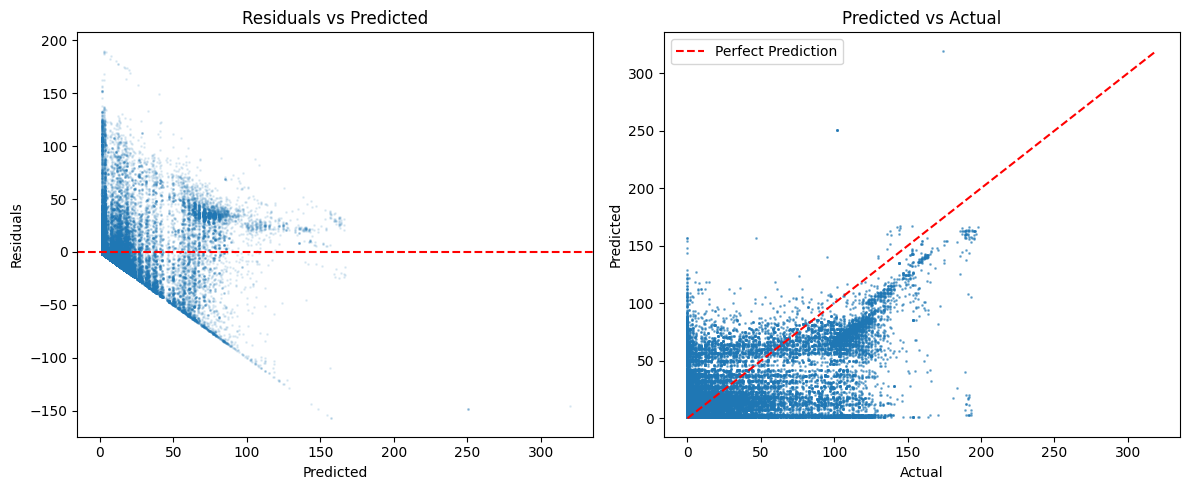

In [15]:
_ = plot_residuals(y_test, y_linear_pred)

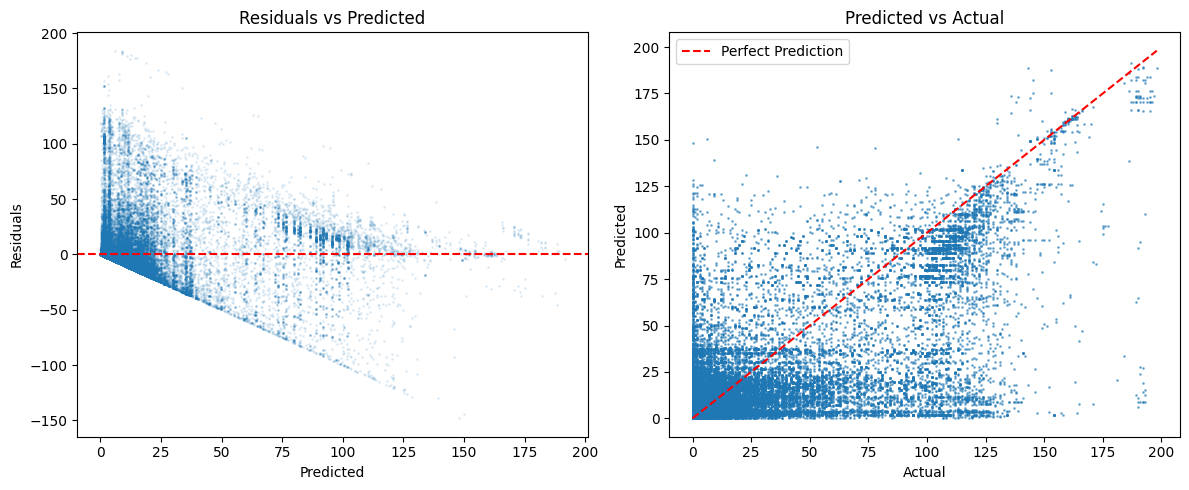

In [16]:
_ = plot_residuals(y_test, y_pred_rf)

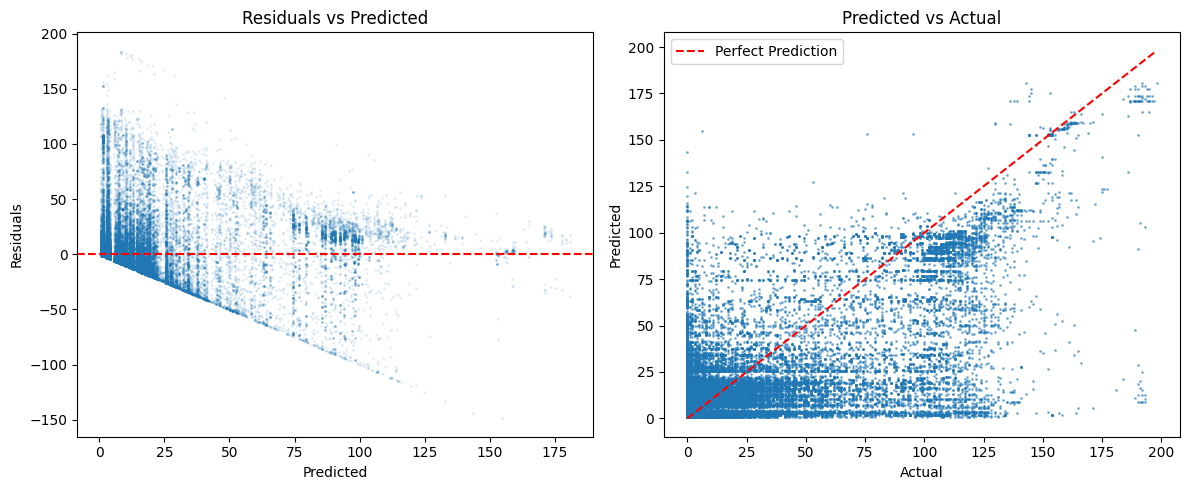

In [17]:
_ = plot_residuals(y_test, y_pred_gb)

In [18]:
def show_result(trained_model):
    print(f"Using model: {trained_model.__class__.__name__}")
    merged_df['Steps_Corrected'] = trained_model.predict(merged_df[FEATURE_COLS])

    # Find all bouts across all subjects
    bouts, durations = findBouts(
        merged_df,
        column_name='Steps_Corrected',
        minimum_threshold=10,        # 10 steps/min
        minimum_duration_in_minutes=5,  # 5+ minute walks
        tolerance=2                  # Allow 2-min gaps (e.g., traffic lights)
    )

    print(f"Found {len(bouts)} total bouts")
    print(f"Durations: {durations[:10]}...")  # First 10

    # Analyze by subject
    for bout in bouts[:3]:  # Show first 3
        subject = bout['Subject'].iloc[0]
        start_time = bout['DateTime'].min()
        duration = len(bout)
        total_steps = bout['Steps_Corrected'].sum()
        print(f"Subject {subject}: {duration} min, {total_steps:.0f} steps, started {start_time}")

    print("\n")
    _ = plot_residuals(merged_df['Steps_Actigraph'], merged_df['Steps_Corrected'])

Using model: LinearRegression
Found 9682 total bouts
Durations: [15, 5, 7, 6, 8, 11, 90, 12, 6, 6]...
Subject 101: 15 min, 260 steps, started 2014-10-21 07:37:00
Subject 101: 5 min, 92 steps, started 2014-10-21 08:05:00
Subject 101: 7 min, 108 steps, started 2014-10-21 12:00:00




/home/nich/projects/inf502-fall2025/Homework 2/model.py:47: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/nich/projects/inf502-fall2025/Homework 2/.venv/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/nich/projects/inf502-fall2025/Homework 2/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


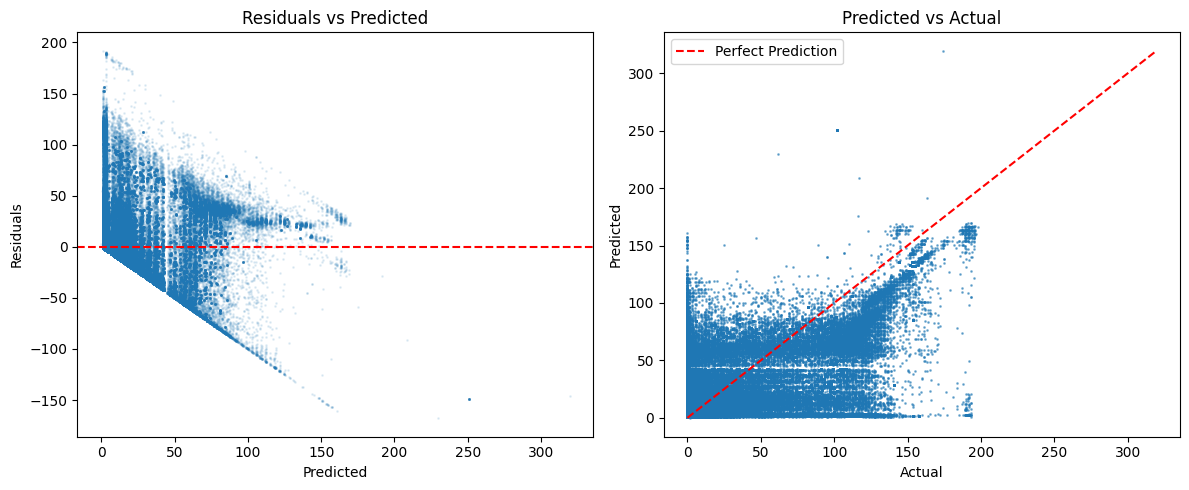

In [19]:
show_result(model)

Using model: RandomForestRegressor
Found 9627 total bouts
Durations: [12, 5, 8, 9, 13, 74, 6, 6, 9, 10]...
Subject 101: 12 min, 201 steps, started 2014-10-21 07:39:00
Subject 101: 5 min, 68 steps, started 2014-10-21 12:00:00
Subject 101: 8 min, 122 steps, started 2014-10-21 18:44:00




/home/nich/projects/inf502-fall2025/Homework 2/model.py:47: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/nich/projects/inf502-fall2025/Homework 2/.venv/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/nich/projects/inf502-fall2025/Homework 2/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


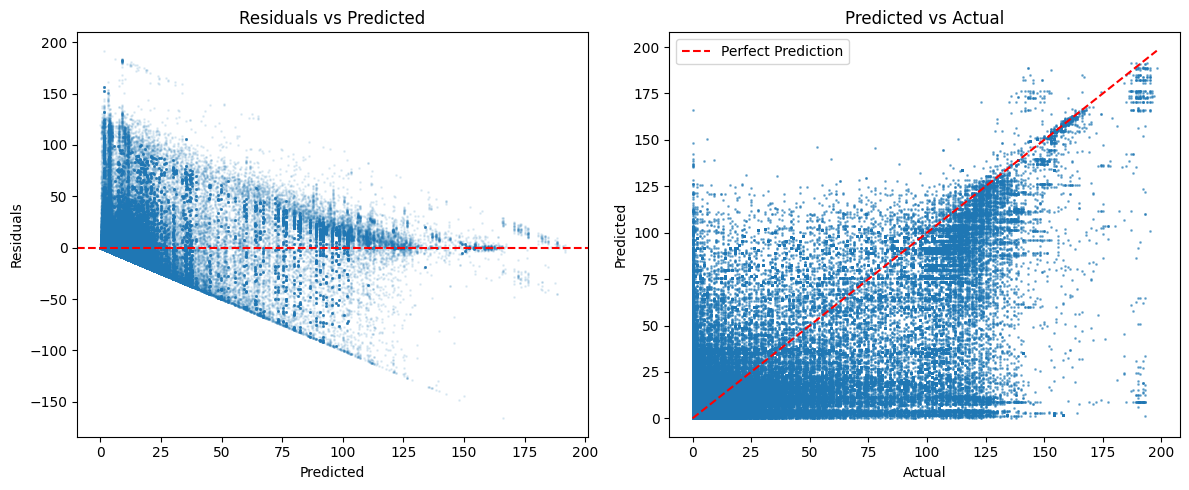

In [20]:
show_result(rf_model)

Using model: GradientBoostingRegressor
Found 9763 total bouts
Durations: [15, 7, 5, 8, 10, 90, 11, 6, 6, 5]...
Subject 101: 15 min, 232 steps, started 2014-10-21 07:37:00
Subject 101: 7 min, 116 steps, started 2014-10-21 12:00:00
Subject 101: 5 min, 82 steps, started 2014-10-21 13:37:00




/home/nich/projects/inf502-fall2025/Homework 2/model.py:47: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/nich/projects/inf502-fall2025/Homework 2/.venv/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/nich/projects/inf502-fall2025/Homework 2/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


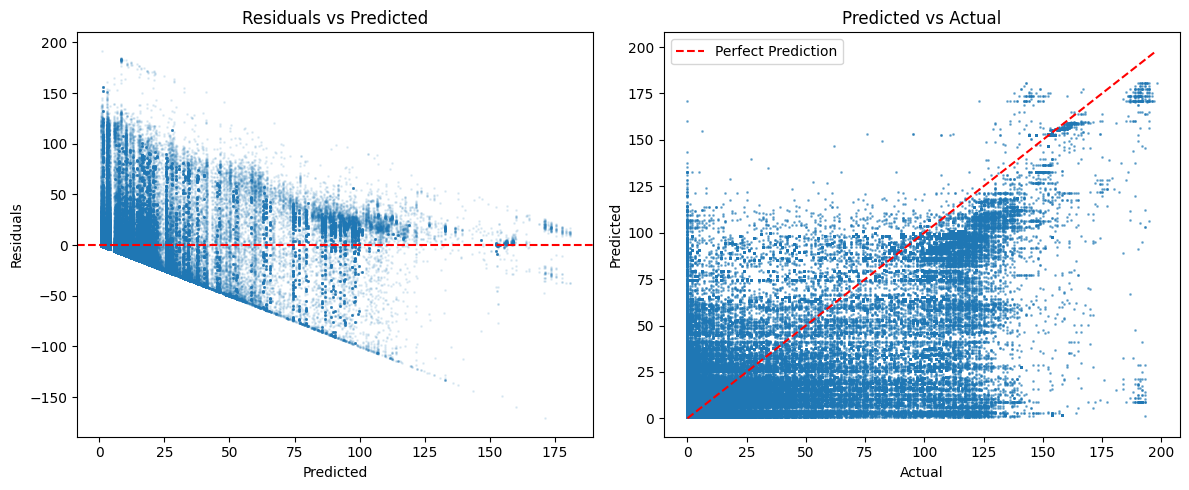

In [21]:
show_result(gb_model)

In [27]:
merged_df['Steps_Corrected'] = gb_model.predict(merged_df[FEATURE_COLS])
merged_df.describe()

,DateTime,Calories,Steps_Fitbit,Intensities,METs,Steps_Actigraph,Steps_Corrected
count,1818605,1.818605e+06,1.818605e+06,1.818605e+06,1.818605e+06,778015.000000,1.818605e+06
mean,2014-11-06 20:17:06.373226496,1.822519e+00,8.037521e+00,3.339219e-01,1.614324e+01,7.351453,6.975968e+00
min,2014-10-21 00:00:00,1.977129e-01,0.000000e+00,0.000000e+00,2.000000e+00,0.000000,5.788404e-01
25%,2014-10-29 10:00:00,9.805000e-01,0.000000e+00,0.000000e+00,1.000000e+01,0.000000,1.572565e+00
50%,2014-11-06 21:17:00,1.310700e+00,0.000000e+00,0.000000e+00,1.000000e+01,0.000000,2.564305e+00
75%,2014-11-15 03:46:00,1.572840e+00,0.000000e+00,0.000000e+00,1.200000e+01,1.000000,3.793912e+00
max,2014-11-23 23:57:00,2.883540e+01,6.210000e+02,3.000000e+00,2.200000e+02,198.000000,1.806862e+02
std,NaN,1.562509e+00,2.283333e+01,7.411824e-01,1.353701e+01,22.464536,1.569521e+01


In [53]:
# Add a 'Week' column (ISO week)
merged_df['Week'] = merged_df['DateTime'].dt.to_period('W').apply(lambda r: r.start_time)

# Aggregate weekly steps by subject
weekly_steps = (
    merged_df
    .groupby(['Subject', 'Week'])['Steps_Corrected']
    .sum()
    .reset_index()
)

weekly_steps.head()

,Subject,Week,Steps_Corrected
0,101,2014-10-20,30171.982966
1,101,2014-10-27,47859.112728
2,101,2014-11-03,59007.151958
3,101,2014-11-10,54661.263585
4,101,2014-11-17,59360.717526


In [63]:
weekly_steps.describe()

,Week,Steps_Corrected
count,115,1.150000e+02
mean,2014-11-03 00:00:00,1.103177e+05
min,2014-10-20 00:00:00,1.988867e+04
25%,2014-10-27 00:00:00,5.014013e+04
50%,2014-11-03 00:00:00,6.129217e+04
75%,2014-11-10 00:00:00,7.619456e+04
max,2014-11-17 00:00:00,1.303935e+06
std,NaN,2.235595e+05


In [54]:
clinical_df = loadClinical()
clinical_df.head()

,age,sex,mass,group,Subject
0,21,female,60.0,adult,101
1,20,female,66.0,adult,102
2,21,female,50.0,adult,103
3,20,female,39.0,adult,104
4,19,female,53.0,adult,105


In [62]:
weekly_steps_merged = weekly_steps.merge(clinical_df, on='Subject', how='left')
weekly_steps_merged.describe()

,Week,Steps_Corrected,age,mass
count,115,1.150000e+02,95.000000,95.000000
mean,2014-11-03 00:00:00,1.103177e+05,21.000000,61.421053
min,2014-10-20 00:00:00,1.988867e+04,19.000000,39.000000
25%,2014-10-27 00:00:00,5.014013e+04,20.000000,51.000000
50%,2014-11-03 00:00:00,6.129217e+04,20.000000,60.000000
75%,2014-11-10 00:00:00,7.619456e+04,21.000000,72.000000
max,2014-11-17 00:00:00,1.303935e+06,37.000000,84.000000
std,NaN,2.235595e+05,3.859225,12.549120


/tmp/ipykernel_243962/3151680695.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subject_steps = weekly_steps_merged.groupby(['Subject', 'age_group'], as_index=False)['Steps_Corrected'].mean()


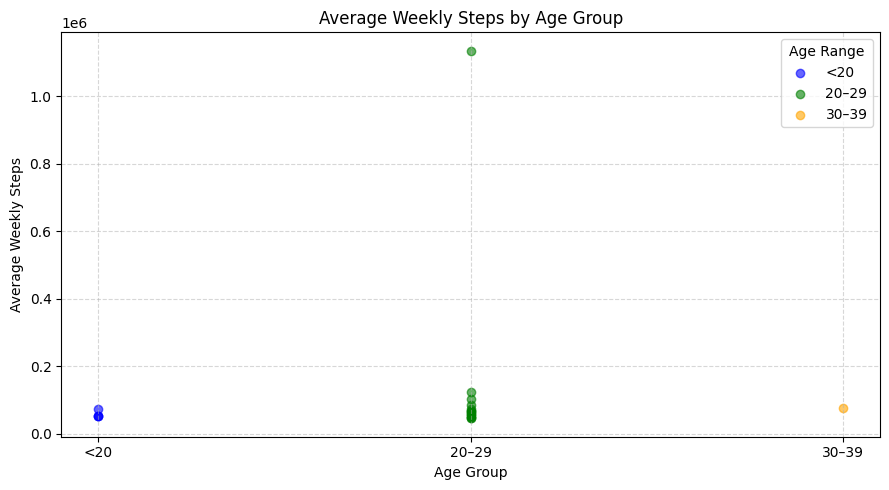

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define age ranges
bins = [0, 20, 30, 40]
labels = ['<20', '20–29', '30–39']
weekly_steps_merged['age_group'] = pd.cut(weekly_steps_merged['age'], bins=bins, labels=labels, right=False)

# Assign colors
colors = {
    '<20': 'blue', '20–29': 'green', '30–39': 'orange',
}
weekly_steps_merged['color'] = weekly_steps_merged['age_group'].map(colors)

# Aggregate by subject
subject_steps = weekly_steps_merged.groupby(['Subject', 'age_group'], as_index=False)['Steps_Corrected'].mean()

# Map categorical labels to numeric x positions
x_labels = labels
x_positions = np.arange(len(x_labels))
x_map = dict(zip(x_labels, x_positions))

subject_steps['x'] = subject_steps['age_group'].map(x_map)

# Plot
plt.figure(figsize=(9,5))
for group, color in colors.items():
    group_data = subject_steps[subject_steps['age_group'] == group]
    plt.scatter(group_data['x'], group_data['Steps_Corrected'], color=color, alpha=0.6, label=group)

plt.xticks(x_positions, x_labels)
plt.title('Average Weekly Steps by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Weekly Steps')
plt.legend(title='Age Range')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
